<a href="https://colab.research.google.com/github/froghop/2DBreastDensityConvNet/blob/main/Summer22_image_classification_tutorial_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to the image classification tutorial. We will be using the PyTorch framework. Some of the code that you see below were adapted from tutorials built into the PyTorch library. You can find additional information here: [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)

In this tutorial, you will be implementing and training convolutional neural networks for image classification of the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset consists of 60,000 images, each with a resolution of 32x32 pixels. The images depict 10 classes and the task at hand is to build a CNN-based model that can accurate predict the class label, given an image.

By the end of this tutorial, you would have encountered common techniques used in supervised machine learning, along with several potential pitfalls. In the next section of the tutorial, you will have the opportunity to design your own experiment to automatically diagnose COVID-19 from x-rays.


In [1]:
# Import python packages that we will use throughout the tutorial
import torch
import fastai.callback.all
from fastai import *
from fastai.vision import *
from fastai.callback import *
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

import copy
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import random
import tarfile
import time
import urllib
import os

# Data Preparation

In [2]:
#For more info on dataset: https://www.cs.toronto.edu/~kriz/cifar.html

# Download CIFAR10 dataset
thetarfile = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
ftpstream = urllib.request.urlopen(thetarfile)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall(path="./data") #extract all paths that start with data

# Load the data from files with pickle format
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Load training data into pandas dataframe
batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
train_df = pd.DataFrame(columns=['Image', 'Label', 'Set'])
for batch in batches:
    train_dict = unpickle(os.path.join('./data/cifar-10-batches-py/', batch))
    images_tr  = [train_dict[b'data'][i,:] for i in range(train_dict[b'data'].shape[0])]
    labels_tr  = train_dict[b'labels']
    d = {'Image': images_tr, 'Label': labels_tr, 'Set': np.zeros(len(images_tr))} #use set for our own reference
    batch_df   = pd.DataFrame(data = d)
    train_df   = pd.concat([train_df, batch_df], ignore_index=True)

In [4]:
# Subset of downloaded training set needs to be split into validation data
val_ratio = 0.2 # Split 20% of training data into validation

# Set random seed for reproducibility of validation split
random.seed(14)
torch.manual_seed(14)
np.random.seed(14)

# Split the training set with artificially pseudorandom distribution between classes
train_labels = list(set(train_df['Label'].values))
for label in train_labels:
    random_sampling = np.random.normal(loc=1, scale=0.1)
    label_indices = list(np.where(train_df['Label'].values == label)[0])
    val_indices   = random.sample(label_indices, int(val_ratio * random_sampling * len(label_indices)))
    # In our dataloader, 'Set' value indicates which set each datapoint belongs. {0: training, 1: validation, 2: test}
    # Here we change 'Set' value of validation datapoints to 1
    train_df.loc[val_indices, 'Set'] = 1

# Separate train and val dataframes
val_df = train_df[train_df['Set'] == 1.0]
train_df = train_df[train_df['Set'] == 0.0]

In [5]:
# Load test data
test_dict  = unpickle('./data/cifar-10-batches-py/test_batch')
images_ts  = [test_dict[b'data'][i,:] for i in range(test_dict[b'data'].shape[0])]
labels_ts  = test_dict[b'labels']
d = {'Image': images_ts, 'Label': labels_ts,'Set': 2*np.ones(len(images_ts))}
test_df    = pd.DataFrame(data = d)

# Append training, validation and test datasets
full_df    = train_df.append(val_df, ignore_index=True).append(test_df, ignore_index=True)

In [6]:
# Load class names
metadata = unpickle('./data/cifar-10-batches-py/batches.meta')
class_names = metadata[b'label_names']

In [7]:
batch_size  = 128

# Form Dataset class that can extract images, corresponding labels of dataset
class CIFARData(Dataset):
    def __init__(self, labels_df, set_name, transforms=None):
        
        if set_name == 'train':
            self.labels_df = labels_df.loc[labels_df.Set == 0, :]
        elif set_name == 'val':
            self.labels_df = labels_df.loc[labels_df.Set == 1, :]
        elif set_name == 'test':
            self.labels_df = labels_df.loc[labels_df.Set == 2, :]
        else:
            print("Wrong set name was given")

        self.images     = list(self.labels_df['Image'])
        self.labels     = list(self.labels_df['Label'])
        self.len        = len(self.labels)
        self.transforms = transforms #for data augmentation

    def __getitem__(self, index):
        'Generates one sample of data'

        image_1d = self.images[index]
        label    = self.labels[index]

        # reshape image into RGB 3-channel, and then transpose dimensions to 3 x 32 x 32
        image    = image_1d.reshape(3, 32, 32)

        # normalize the image to [0,1]
        image = (image - np.min(image))/(np.max(image) - np.min(image))

        # Convert image from numpy array to pytorch tensor
        #image = np.expand_dims(image, 0)  # (1, 32, 448, 448)
        image = image.astype(np.float64)
        image = torch.from_numpy(image)

        if self.transforms:
            image = transform(image)

        label = torch.from_numpy(np.asarray(label))
        return image.type(torch.FloatTensor), label.type(torch.LongTensor)

    def __len__(self):
        return self.len

trainset = CIFARData(labels_df=full_df, set_name='train')
valset   = CIFARData(labels_df=full_df, set_name='val')
testset  = CIFARData(labels_df=full_df, set_name='test')
print("Length of training set:", trainset.len)
print("Length of validation set:", valset.len)
print("Length of test set:", testset.len)

# Create dataloaders
trainset_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                             num_workers=1,
                             drop_last=True)

valset_loader = DataLoader(valset, batch_size=batch_size, shuffle=False,
                             num_workers=1,
                             drop_last=False)

testset_loader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                             num_workers=1,
                             drop_last=False)

Length of training set: 40094
Length of validation set: 9906
Length of test set: 10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


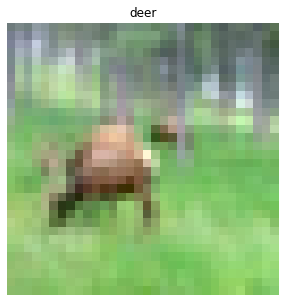

In [8]:
# Visualize a random image in the training set
ind = np.round(np.random.rand() * len(trainset)).astype(np.int)
img = trainset.__getitem__(ind)[0].numpy()[:, :, :].transpose((1, 2, 0))
label = class_names[trainset.__getitem__(ind)[1].numpy()].decode('utf-8')
fig = plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(label)
plt.axis('off');

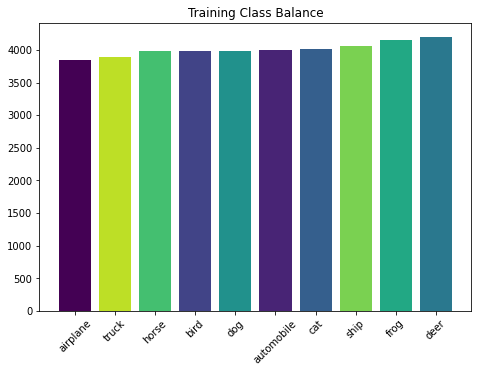

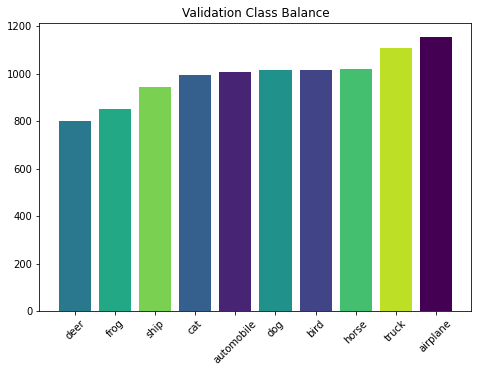

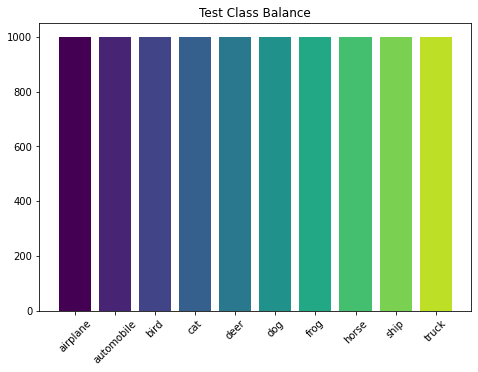

In [9]:
# Evaluate class balance

# Create bar plot of class counts
def show_class_counts(class_labels, class_counts, class_names, title=None):
    classes = [class_names[i].decode('utf-8') for i in class_labels]
    cmap = plt.get_cmap('viridis')
    color = cmap(np.array(class_labels) / len(class_names))

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(classes, class_counts, color=color)
    ax.set_xticklabels(classes, rotation=45)
    if title is not None:
        plt.title(title)
    plt.show()

# Gets the smallest and largest n classes
def count_smallest_largest(df, n, class_names):
    class_counts = np.zeros(len(class_names))
    labels, counts = np.unique(df['Label'].values, return_counts=True)
    ind = np.argsort(counts)
    abb_labels = list(labels[ind[:5]]) + list(labels[ind[-5:]])
    abb_counts = list(counts[ind[:5]]) + list(counts[ind[-5:]])

    return abb_labels, abb_counts

train_labels, train_counts = count_smallest_largest(train_df, 10, class_names)
val_labels, val_counts = count_smallest_largest(val_df, 10, class_names)
test_labels, test_counts = count_smallest_largest(test_df, 10, class_names)

# Show class balance
show_class_counts(train_labels, train_counts, class_names, title='Training Class Balance')
show_class_counts(val_labels, val_counts, class_names, title='Validation Class Balance')
show_class_counts(test_labels, test_counts, class_names, title='Test Class Balance')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Transformed: horse')

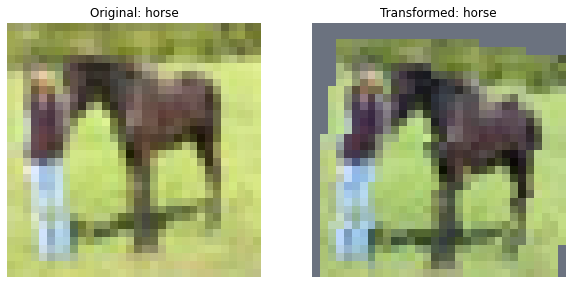

In [10]:
# DATA AUGMENTATION

# List of random image transformations for data augmentation
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10, fill=0.5), #(degree of rot, fill)
                                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0.5),
                                transforms.Normalize((0.485, 0.456, 0.406), # (means of dataset)
                                                     (0.229, 0.224, 0.225))]) #standard dev of color channels
                                                     #need these values if using pretrained model

ind         = np.round(np.random.rand() * len(trainset)).astype(np.int)
original    = trainset.__getitem__(ind)[0]
transformed = transform(original)
label = class_names[trainset.__getitem__(ind)[1].numpy()].decode('utf-8')

# Plot the original image
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original[:, :, :].numpy().transpose(1, 2, 0))
plt.clim([0,1])
plt.axis('off')
plt.title('Original: ' + label)

# Plot an example of the transformed image
plt.subplot(1,2,2)
tf_img = transformed[:, :, :].numpy().transpose(1, 2, 0)
# Purely for visualization purposes, scale pixel values to be from [0,1]. 
# Actual DL network would not do this last step (normalized output would be sufficient)
tf_img = (tf_img - np.min(tf_img))/(np.max(tf_img) - np.min(tf_img))
plt.imshow(tf_img)
plt.clim([0,1])
plt.axis('off')
plt.title('Transformed: ' + label)

In [11]:
# Reinitialize dataloaders to include data augmentations
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10, fill=0.5),
                                       transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0.5),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                                            (0.229, 0.224, 0.225))])
normalize_transforms = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), 
                                                                (0.229, 0.224, 0.225))])

trainset = CIFARData(labels_df=full_df, set_name='train', transforms=train_transforms)
valset = CIFARData(labels_df=full_df, set_name='val', transforms=normalize_transforms)
testset = CIFARData(labels_df=full_df, set_name='test', transforms=normalize_transforms)

trainset_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                             num_workers=1,
                             drop_last=True)
valset_loader = DataLoader(valset, batch_size=batch_size, shuffle=True,
                             num_workers=1,
                             drop_last=False)
testset_loader = DataLoader(testset, batch_size=batch_size, shuffle=True,
                             num_workers=1,
                             drop_last=False)

full_df = train_df.append(val_df, ignore_index=True).append(test_df, ignore_index=True)

# Designing the Learning Framework

In this section, you will be testing two architectures. First, a basic convolutional neural network with 2 convolutional layers followed by 3 fully connected layers. And second, a pre-designed architecture called a ResNet, which won the ImageNet ILSVRC competition in 2015.

With each 

In [12]:
# MODEL

# Basic CNN
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(color channel, num filters, conv kernal size)
        self.pool = nn.MaxPool2d(2, 2) #receptive feels
        self.conv2 = nn.Conv2d(6, 16, 5) #input, 16 ouput, filter size
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #noes after flattening, goes to 120 nodes
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #10 = number of classes trying to predict

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
!pip install torchviz
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


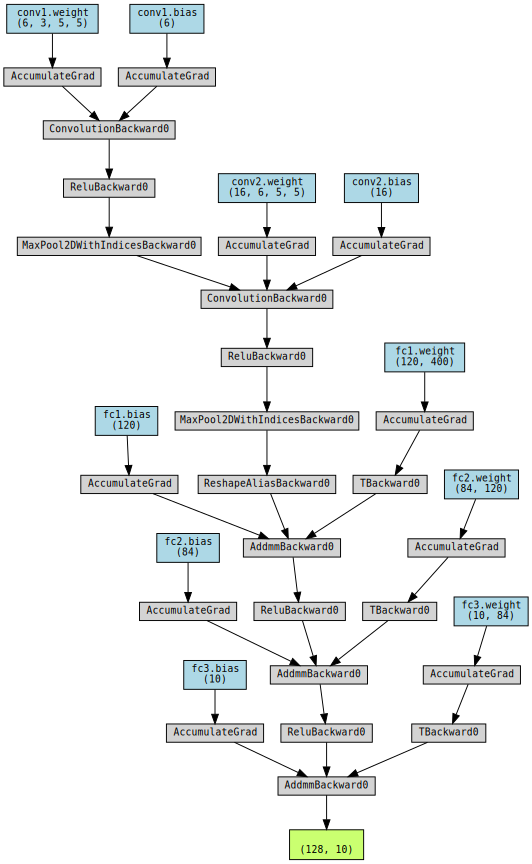

In [14]:
model1 = ConvNet()

batch = next(iter(trainset_loader))
yhat = model1(batch[0])
make_dot(yhat, params=dict(list(model1.named_parameters())))

In [15]:
# Assign model to GPU
print("GPU available: ", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
print("Model successfully assigned to:", device)

GPU available:  True
Model successfully assigned to: cuda


In [16]:
# Set hyperparameters
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
# TRAIN MODEL
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25, return_stats=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_losses = {'train': [], 'val': []}
    epoch_accs = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) #move to gpu
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad() #ignore previous iterations buildup

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): #now start keeping track of gradients
                    outputs = model(inputs) #batch size by number of classes,
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) #compute loss

                    # backward + optimize only if in training phase
                    if phase == 'train': #tuning model
                        loss.backward() #take loss, backpropogate it
                        optimizer.step() 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])

            epoch_losses[phase].append(epoch_loss)
            epoch_accs[phase].append(epoch_acc.cpu().numpy())

            print('{} loss: {:.4f} acc: {:.4f}%'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc: #save model to select best model
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    if return_stats:
        return model, epoch_losses, epoch_accs
    else:
        return model

In [18]:
dataloaders = {'train': trainset_loader, 'val': valset_loader}
model1, losses, accs = train_model(dataloaders, model1, criterion, optimizer, scheduler, num_epochs, return_stats=True)

Epoch 0/9
----------
train loss: 294.2838 acc: 15.7252%
val loss: 291.5474 acc: 17.3333%

Epoch 1/9
----------
train loss: 289.0824 acc: 24.3259%
val loss: 275.0742 acc: 25.1282%

Epoch 2/9
----------
train loss: 262.0420 acc: 31.9329%
val loss: 251.2319 acc: 35.3590%

Epoch 3/9
----------
train loss: 245.0691 acc: 38.6454%
val loss: 236.7473 acc: 41.9103%

Epoch 4/9
----------
train loss: 232.5474 acc: 43.2077%
val loss: 225.8703 acc: 45.4103%

Epoch 5/9
----------
train loss: 222.7288 acc: 46.6134%
val loss: 218.2185 acc: 47.4872%

Epoch 6/9
----------
train loss: 216.0270 acc: 48.8147%
val loss: 211.7077 acc: 49.6154%

Epoch 7/9
----------
train loss: 210.8183 acc: 50.5942%
val loss: 209.0998 acc: 49.8333%

Epoch 8/9
----------
train loss: 210.2264 acc: 51.0895%
val loss: 208.7847 acc: 51.0897%

Epoch 9/9
----------
train loss: 209.4400 acc: 51.4792%
val loss: 208.4597 acc: 50.5385%

Training complete in 7m 39s
Best val accuracy: 51.089744


In [19]:
# If you want to save your model to your Google Drive so you can access it in the future, you'll need to mount your personal Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
# Save your model to the path designated below '/content/gdrive/MyDrive/YOUR_PATH'
save_path = '/content/gdrive/MyDrive/cnn_tutorial_ci2'
torch.save(model1.state_dict(), save_path)

stats = {'losses': losses, 'accs': accs,}

with open('/content/gdrive/MyDrive/cnn_tutorial_ci2_stats.pkl', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# (INSTRUCTOR ONLY) Load model
model1.load_state_dict(torch.load('/content/gdrive/MyDrive/cnn_tutorial_ci2'))
model1.eval()
# (INSTRUCTOR ONLY) Load stats
stats = pickle.load(open('/content/gdrive/MyDrive/cnn_tutorial_ci2_stats.pkl', 'rb'))
losses = stats['losses']
accs = stats['accs']

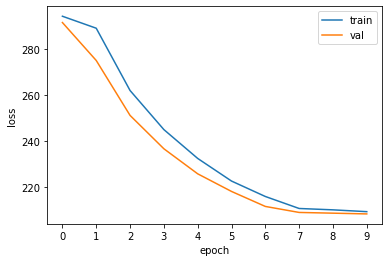

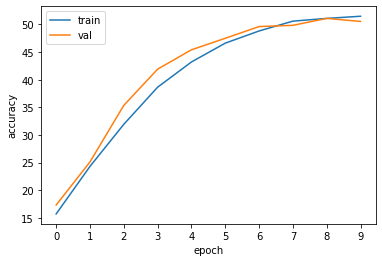

In [21]:
# Plot loss per epoch
plt.figure()
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(losses['train'])))
plt.ylabel('loss')
plt.legend(['train', 'val'])

# Plot accuracy per epoch
plt.figure()
plt.plot(accs['train'])
plt.plot(accs['val'])
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(accs['train'])))
plt.ylabel('accuracy')
plt.legend(['train', 'val'])

Best epoch: 9


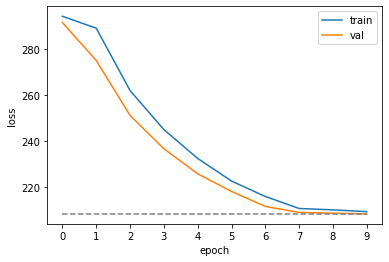

In [22]:
min_val_loss = np.min(losses['val'])
epoch_at_min_val_loss = np.where(losses['val'] == min_val_loss)[0]
print("Best epoch:", epoch_at_min_val_loss[0])

# Plot losses, showing lowest validation loss
plt.figure()
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.plot([0, len(losses['val']) - 1], [min_val_loss, min_val_loss], c='gray', linestyle='dashed')
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(losses['train'])))
plt.ylabel('loss')
plt.legend(['train', 'val'])

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_predictions(dataloader, model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

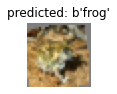

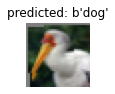

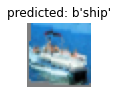

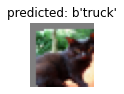

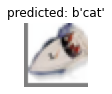

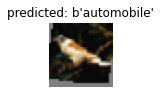

In [24]:
visualize_predictions(testset_loader, model1)

In [25]:
def test_accuracy(dataloader, model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad(): 
        for data in dataloader:
            images, labels = data
            images = images.to(device) #move to gpu
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

overall_acc = test_accuracy(testset_loader, model1)

print('Accuracy of the network on the test images: %d %%' % overall_acc)

Accuracy of the network on the test images: 40 %


In [26]:
def test_accuracy_per_class(dataloader, class_names, model):
    # prepare to count predictions for each class
    correct_pred = {name: 0 for name in class_names}
    total_pred = {name: 0 for name in class_names}
    acc = {name: 0 for name in class_names}

    # no gradients needed
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[class_names[label]] += 1
                total_pred[class_names[label]] += 1

    for name, correct_count in correct_pred.items():
        acc[name] = 100 * float(correct_count) / total_pred[name]

    return acc

# print accuracy for each class
acc_by_class = test_accuracy_per_class(testset_loader, class_names, model1)
acc_by_class = dict(sorted(acc_by_class.items(), key=lambda item: item[1]))

for name, accuracy in acc_by_class.items():
    print("Accuracy for class {:5s} is: {:.1f} %".format(name.decode('utf-8'), accuracy))

Accuracy for class bird  is: 13.5 %
Accuracy for class cat   is: 19.2 %
Accuracy for class deer  is: 24.0 %
Accuracy for class dog   is: 41.3 %
Accuracy for class airplane is: 45.0 %
Accuracy for class truck is: 47.6 %
Accuracy for class ship  is: 48.8 %
Accuracy for class horse is: 51.1 %
Accuracy for class automobile is: 56.3 %
Accuracy for class frog  is: 60.5 %


In [27]:
model2 = models.resnet18()
#model2 = models.resnet152()
#model2 = models.vgg16()
#model2 = models.squeezenet1_0()
#model2 = models.alexnet()
#model2 = models.mobilenet_v2()

In [28]:
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

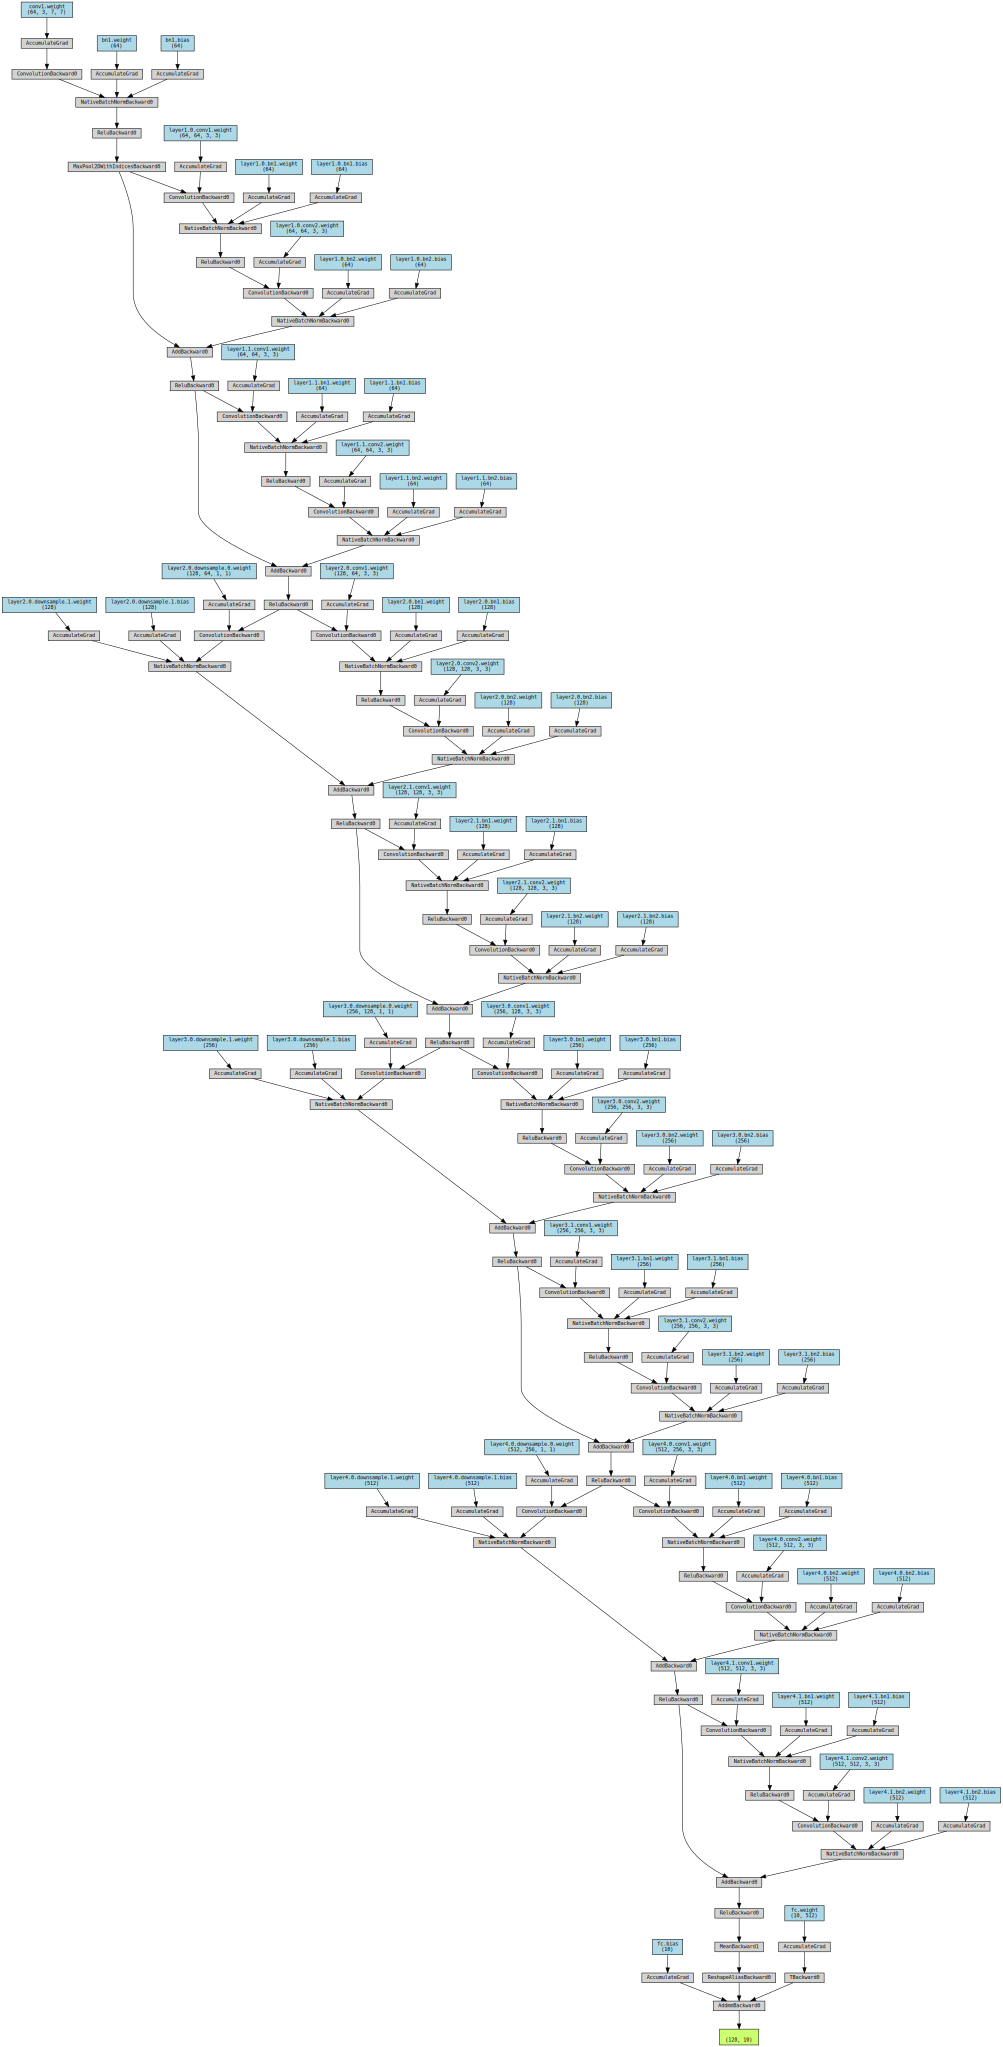

In [29]:
num_ftrs = model2.fc.in_features #to change fully connected layer to output only 10 classes
model2.fc = nn.Linear(num_ftrs, len(class_names))

batch = next(iter(trainset_loader))
yhat = model2(batch[0])
make_dot(yhat, params=dict(list(model2.named_parameters())))

In [30]:
num_epochs = 10
lr = 0.001

model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dataloaders = {'train': trainset_loader, 'val': valset_loader}
model2, losses2, accs2 = train_model(dataloaders, model2, criterion, optimizer, scheduler, num_epochs, return_stats=True)

# Save your model to the path designated below '/content/gdrive/MyDrive/YOUR_PATH'
save_path = '/content/gdrive/MyDrive/res_net_2022_basic'
torch.save(model2.state_dict(), save_path)

stats = dict()
stats['losses'] = losses2
stats['accs'] = accs2
pickle.dump(stats, open('/content/gdrive/MyDrive/res_net_basic_stats.pkl', 'wb'))

Epoch 0/9
----------
train loss: 232.8363 acc: 42.4313%
val loss: 201.5663 acc: 53.1154%

Epoch 1/9
----------
train loss: 190.6586 acc: 58.4569%
val loss: 182.5324 acc: 60.9103%

Epoch 2/9
----------
train loss: 175.5811 acc: 64.2460%
val loss: 173.0469 acc: 64.3462%

Epoch 3/9
----------
train loss: 165.1630 acc: 68.2268%
val loss: 161.8435 acc: 68.8333%

Epoch 4/9
----------
train loss: 156.6802 acc: 71.3994%
val loss: 153.0896 acc: 71.3462%

Epoch 5/9
----------
train loss: 149.3025 acc: 74.2364%
val loss: 147.9438 acc: 73.5000%

Epoch 6/9
----------
train loss: 142.6962 acc: 76.9681%
val loss: 148.1941 acc: 73.8333%

Epoch 7/9
----------
train loss: 134.9714 acc: 79.6294%
val loss: 140.0531 acc: 76.3205%

Epoch 8/9
----------
train loss: 132.6124 acc: 80.7252%
val loss: 139.2631 acc: 77.1795%

Epoch 9/9
----------
train loss: 131.1730 acc: 81.0767%
val loss: 136.7835 acc: 78.0385%

Training complete in 8m 53s
Best val accuracy: 78.038462


In [ ]:
# (INSTRUCTOR ONLY) Load model
model2.load_state_dict(torch.load('/content/gdrive/MyDrive/res_net_2022_basic'))
model2.eval()

# (INSTRUCTOR ONLY) Load stats
stats2 = pickle.load(open('/content/gdrive/MyDrive/res_net_basic_stats.pkl', 'rb'))
losses2 = stats2['losses']
accs2 = stats2['accs']

In [31]:
overall_acc = test_accuracy(testset_loader, model2)

print('Accuracy of the network on the test images: %d %%' % overall_acc)

Accuracy of the network on the test images: 61 %


In [32]:
acc_by_class = test_accuracy_per_class(testset_loader, class_names, model2)
acc_by_class = dict(sorted(acc_by_class.items(), key=lambda item: item[1]))

for name, accuracy in acc_by_class.items():
    print("Accuracy for class {:5s} is: {:.1f} %".format(name.decode('utf-8'), accuracy))

Accuracy for class cat   is: 39.2 %
Accuracy for class bird  is: 46.9 %
Accuracy for class deer  is: 55.6 %
Accuracy for class dog   is: 56.1 %
Accuracy for class airplane is: 65.2 %
Accuracy for class horse is: 66.1 %
Accuracy for class truck is: 68.0 %
Accuracy for class automobile is: 70.5 %
Accuracy for class frog  is: 73.4 %
Accuracy for class ship  is: 76.1 %


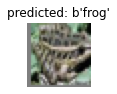

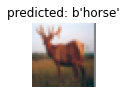

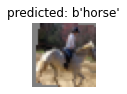

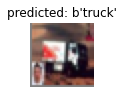

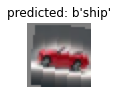

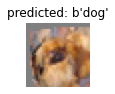

In [33]:
visualize_predictions(testset_loader, model2)

In [34]:
#get metric report with sklearn
preds = []
preds=np.array(preds)
lbls_test = []
lbls_test = np.array(lbls_test)
with torch.no_grad():
        for data in testset_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            preds = np.hstack([preds, predicted.to('cpu').numpy()]) if preds.size else predicted.to('cpu').numpy()
            lbls_test = np.hstack([lbls_test, labels.to('cpu').numpy()]) if lbls_test.size else labels.to('cpu').numpy()
from sklearn.metrics import classification_report
print(classification_report(lbls_test, preds, target_names=[class_name.decode('utf-8') for class_name in class_names]))

              precision    recall  f1-score   support

    airplane       0.65      0.64      0.65      1000
  automobile       0.70      0.69      0.70      1000
        bird       0.52      0.47      0.50      1000
         cat       0.42      0.38      0.40      1000
        deer       0.55      0.56      0.55      1000
         dog       0.51      0.55      0.53      1000
        frog       0.65      0.70      0.68      1000
       horse       0.68      0.66      0.67      1000
        ship       0.71      0.74      0.73      1000
       truck       0.67      0.69      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



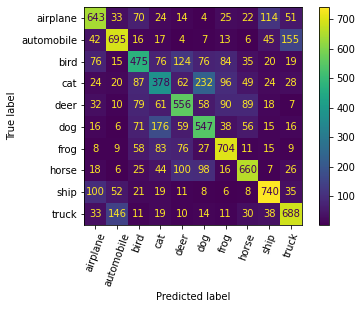

In [35]:
#get confusion matrix
import sklearn
confusion_matrix=sklearn.metrics.confusion_matrix(lbls_test, preds,)
dd_mat = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=[class_name.decode('utf-8') for class_name in class_names])
dd_mat.plot(include_values=True, cmap='viridis', xticks_rotation=70, values_format=None, ax=None, colorbar=True)

Best epoch: 9


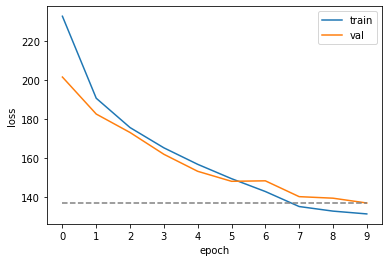

In [36]:
min_val_loss2 = np.min(losses2['val'])
epoch_at_min_val_loss2 = np.where(losses2['val'] == min_val_loss)[0]
print("Best epoch:", epoch_at_min_val_loss[0])

# Plot losses, showing lowest validation loss
plt.figure()
plt.plot(losses2['train'])
plt.plot(losses2['val'])
plt.plot([0, len(losses2['val']) - 1], [min_val_loss2, min_val_loss2], c='gray', linestyle='dashed')
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(losses2['train'])))
plt.ylabel('loss')
plt.legend(['train', 'val'])

In [37]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [38]:
print("Number of parameters in ConvNet:", get_n_params(model1))

Number of parameters in ConvNet: 62006


In [39]:
print("Number of parameters in ResNet18 (or alternative):", get_n_params(model2))

Number of parameters in ResNet18 (or alternative): 11181642
